In [227]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Import Print function
from __future__ import print_function

In [3]:
# Add manual seed for deterministic results
import torch
torch.manual_seed(1)

# Set Constant Values
batch_size = 64
ricap_beta = 0.4
class_map = {
    'PLANE': 0,
    'CAR': 1,
    'BIRD': 2,
    'CAT': 3,
    'DEER': 4,
    'DOG': 5,
    'FROG': 6,
    'HORSE': 7,
    'SHIP': 8,
    'TRUCK': 9
}

# Enable or disable visualizations
show_summary = True
show_dataset_analyze = True

In [4]:
from woolly.utils import get_device

# Check GPU availability
use_cuda, device = get_device()

In [5]:
# Load test and train loaders
from woolly.dataset import get_cifar_loader, get_advance_cifar_loader
# Get transforme functions
from woolly.transform import BASE_PROFILE, get_transform

import json

train_profile = {
    'normalize': BASE_PROFILE['normalize'],
    'shift_scale_rotate': BASE_PROFILE['shift_scale_rotate'],
    'crop_and_pad': BASE_PROFILE['crop_and_pad'],
    'random_brightness_contrast': BASE_PROFILE['random_brightness_contrast'],
    'horizontal_flip': BASE_PROFILE['horizontal_flip'],
    'to_gray': BASE_PROFILE['to_gray'],
    'coarse_dropout': BASE_PROFILE['coarse_dropout'],
    'to_tensor':  BASE_PROFILE['to_tensor'],
}

normalize = {
    'normalize': BASE_PROFILE['normalize'],
    'to_tensor':  BASE_PROFILE['to_tensor'],
}

course_dropout = {
    'coarse_dropout': BASE_PROFILE['coarse_dropout'],
}

ricap_profile = {
    'p': 0.3,
    'ricap_beta': ricap_beta
}

# course_dropout['coarse_dropout']['p'] = 0.3
# course_dropout['coarse_dropout']['min_height'] = 8
# course_dropout['coarse_dropout']['min_width'] = 8

print('Train Profile:', json.dumps(train_profile, indent = 4))
print('Normalize Profile:', json.dumps(normalize, indent = 4))
print('Course Dropout Profile:', json.dumps(course_dropout, indent = 4))
print('Ricap Profile:', json.dumps(ricap_profile, indent = 4))

# # create train and test loaders with transforms
# train_loader, test_loader = get_advance_cifar_loader(
#     base_transform=get_transform(train_profile),
#     normalize=get_transform(normalize),
# #     apply_ricap=ricap_profile,
# #     apply_cutout=get_transform(course_dropout),
#     batch_size=batch_size, 
#     use_cuda=use_cuda
# )

train_loader, test_loader = get_cifar_loader(get_transform(train_profile), get_transform(normalize), batch_size=batch_size, use_cuda=use_cuda)

Train Profile: {
    "shift_scale_rotate": {
        "shift_limit": 0.15,
        "scale_limit": 0.15,
        "rotate_limit": 10,
        "p": 0.3
    },
    "crop_and_pad": {
        "px": [
            0,
            6
        ],
        "pad_mode": 1,
        "p": 0.3
    },
    "random_brightness_contrast": {
        "p": 0.3
    },
    "horizontal_flip": {
        "p": 0.3
    },
    "to_gray": {
        "p": 0.3
    },
    "normalize": {
        "mean": [
            0.4914,
            0.4822,
            0.4465
        ],
        "std": [
            0.247,
            0.2435,
            0.2616
        ]
    },
    "coarse_dropout": {
        "max_holes": 1,
        "max_height": 16,
        "max_width": 16,
        "min_holes": 1,
        "min_height": 8,
        "min_width": 8,
        "fill_value": [
            0.4914,
            0.4822,
            0.4465
        ],
        "p": 0.3
    },
    "to_tensor": true
}
Normalize Profile: {
    "normalize": {
        "mean": [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

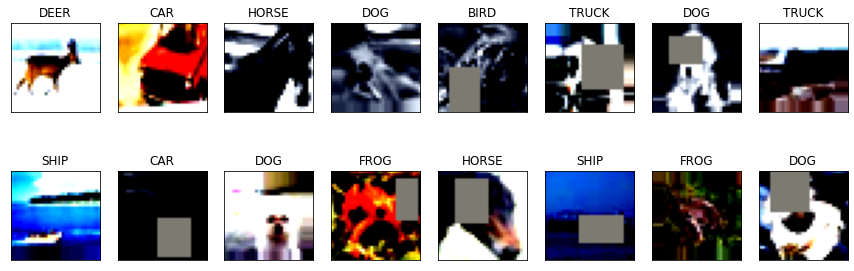

In [6]:
# We will now visualize DataSet by printing data scale and some samples
from woolly.visualize import print_class_scale, print_samples, print_samples_native
if show_dataset_analyze:
    # print class scale
#     print_class_scale(train_loader, class_map)
    # print data samples
#     print_samples_native(train_loader, class_map)
    print_samples(train_loader, class_map)

## Load and Train Network

1. Here we will first set all hyper parameters
2. Create moidel instance
3. Print Model summary
4. Run training for all three model techniques

In [11]:
from woolly.model import WyCifar10Net
from woolly.backpropagation import train, train_ricap, train_native, test, test_native, get_sgd_optimizer, get_crossentropy_criteria
from woolly.utils import initialize_weights, print_modal_summary, print_summary
from woolly.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from woolly.training import Training

# Set Hyper Parameters Train Params
epochs = 25
lr = 0.05
max_lr = 0.5
steps_per_epoch = len(train_loader)
dropout = False
drop_ratio = 0.1
use_l1 = False
lambda_l1 = 1e-7
momentum = 0.9
weight_decay = 0.000125
weight_decay = weight_decay/batch_size

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("Dropout Ratio:", drop_ratio)
print("Momentum:", momentum)
print("Weight Decay:", weight_decay)
print("Use L1:", use_l1)
print("L1 Lambda:", lambda_l1)
print("RICAP Beta", ricap_beta)


# Batch Normalization Technique to be used
norm='bn'
use1x1=True
ctype='depthwise_seperable'
base_channels=16
repetations=1
usedilation=False
use_skip=False
train_function=train
test_function=test

# Create an instance of train function which uses ricap augumented images
ctrain = train_function(use_l1=use_l1, lambda_l1=lambda_l1)

# Create model instance based on parameter which one to use
model = WyCifar10Net(
    image=(32, 32), 
    ctype=ctype, 
    use1x1=use1x1, 
    base_channels=base_channels, 
    layers=repetations, 
    drop_ratio=drop_ratio, 
    usedilation=usedilation, 
    use_skip=use_skip
).apply(initialize_weights).to(device)

# Create optimizer instance based on hyper parameters
optimizer = get_sgd_optimizer(model, lr=lr, momentum=momentum, weight_decay=weight_decay)
criteria = get_crossentropy_criteria(device)

# Create Pytorch One Cycle scheduler instance
# pytorch_scheduler = one_cycle_lr_pt(
#     optimizer, 
#     lr=lr, 
#     max_lr=max_lr, 
#     steps_per_epoch=steps_per_epoch, 
#     epochs=epochs, 
#     anneal_strategy='linear'
# )

import numpy as np
schedule = np.interp(np.arange(epochs+1), [0, 7, epochs], [lr, max_lr, lr/20.0])

# Create Custom One Cycle schedule instance
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs,
    schedule=schedule
)

# Create instance of trainer with all params
trainer = Training(
    model,
    optimizer,
    criteria,
    custom_scheduler,
    ctrain,
    test_function,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

if show_summary:
#     print_summary(model, input_size=(3, 32, 32))
    print_modal_summary(trainer.model)
# Run trainer
trainer.run()

Using Device: cuda
Epochs: 25
Lr: 0.05
Max Lr: 0.5
Batch Size: 64
Dropout: False
Dropout Ratio: 0.1
Momentum: 0.9
Weight Decay: 1.953125e-06
Use L1: False
L1 Lambda: 1e-07
RICAP Beta 0.4
----------------------------------------------------------------
| Name                     	Shape               	Params |
----------------------------------------------------------------
| b1.conv1.conv            	[32, 3, 3, 3]       	   864 |
| b1.bn1                   	[32]                	    32 |
| b1.bn1                   	[32]                	    32 |
| b1.conv2.conv            	[32, 32, 3, 3]      	  9216 |
| b1.bn2                   	[32]                	    32 |
| b1.bn2                   	[32]                	    32 |
| b2.conv.0.conv1.conv     	[32, 1, 3, 3]       	   288 |
| b2.conv.0.conv1.pointwise	[64, 32, 1, 1]      	  2048 |
| b2.conv.0.bn1            	[64]                	    64 |
| b2.conv.0.bn1            	[64]                	    64 |
| b2.conv.0.conv2.conv     	[64, 1, 3, 3]    

## Grad Cam

Here we will implement gradcoam on different images

In [310]:
from torch.utils.data import Dataset
import glob
from PIL import Image

class WyCustomDataset(Dataset):
    def __init__(self, transforms=None):
        self.img_dim = (32, 32)
        self.transforms = transforms
        self.idata = []
        self.ilabel = []
        
        self.class_map = {
            'PLANE': 0,
            'CAR': 1,
            'BIRD': 2,
            'CAT': 3,
            'DEER': 4,
            'DOG': 5,
            'FROG': 6,
            'HORSE': 7,
            'SHIP': 8,
            'TRUCK': 9
        }
        
        # Read Dataset
        self.images = glob.glob('./data/**/*.jpg')
        
        for image in self.images:
            self.ilabel.append(self.class_map[image.split('/')[2].upper()])
            self.idata.append(image)

    def __len__(self):
        return len(self.idata)

    def __getitem__(self, idx):
        # Read Image and Label
        im_path = self.idata[idx]
        label = self.ilabel[idx]
        
        # open method used to open different extension image file
        img = Image.open(im_path, 'r') 
        
        # Apply Transforms
        if self.transforms is not None:
            img = self.transforms(img)

        return img, label, im_path

In [311]:
# Create dataset to load images

import torch
import torch.nn as nn
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((32, 32)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])])

# define a 1 image dataset
dataset = WyCustomDataset(transforms=transform) # datasets.ImageFolder(root='./data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [312]:
class GradCAM(nn.Module):
    def __init__(self, model):
        super(GradCAM, self).__init__()
        
        # get the pretrained network
        self.wy = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.wy.feature
        
        # get the classifier of the model
        self.classifier = self.wy.classifier
        
        # placeholder for the gradients
        self.gradients = None
        
        self.classes = self.wy.classes
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.classifier(x)

        x = x.view(-1, self.classes)
        
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

**Drawing CAM**

First, let’s make the forward pass through the network with the image of the elephants and see what the VGG19 predicts. Don’t forget to set your model into the evaluation mode, otherwise you can get very random results:

In [313]:
# initialize the VGG model
gradcam = GradCAM(model).to(device)

# set the evaluation mode
gradcam.eval()

# get the image from the dataloader
loader = iter(dataloader)
img, label, (impath,) = next(loader)
img = img.to(device)

# get the most likely prediction of the model
pred = gradcam(img)#.argmax(dim=1)

In [314]:
pred.argmax(dim=1).item()

5

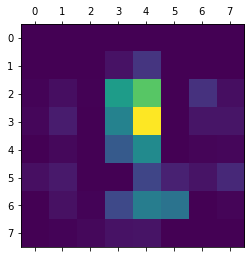

In [315]:
# get the gradient of the output with respect to the parameters of the model
pred[:, pred.argmax(dim=1).item()].backward()

# pull the gradients out of the model
gradients = gradcam.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = gradcam.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(128):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu(), 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

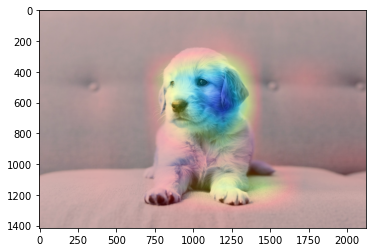

In [316]:
import cv2
img = cv2.imread(impath)
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
plt.imshow(superimposed_img / superimposed_img.max())

## Analyze Network

We will print comparison between train and test accuries and incorrect predictions

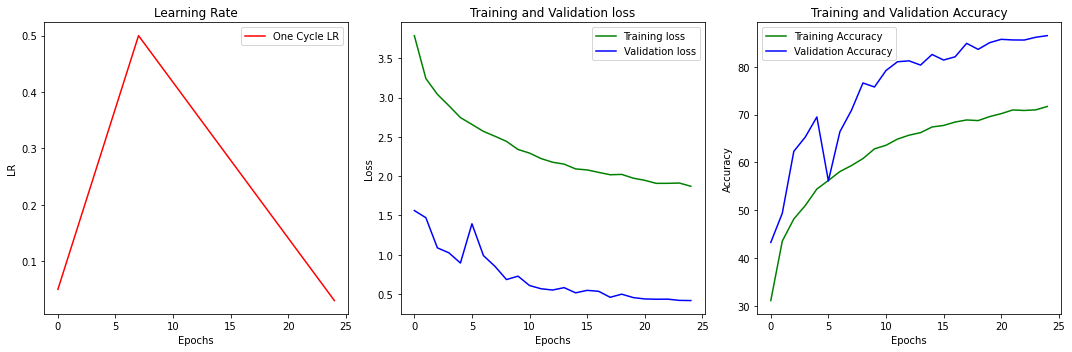

Confusion matrix, without normalization


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Incorrect Predictions 1349


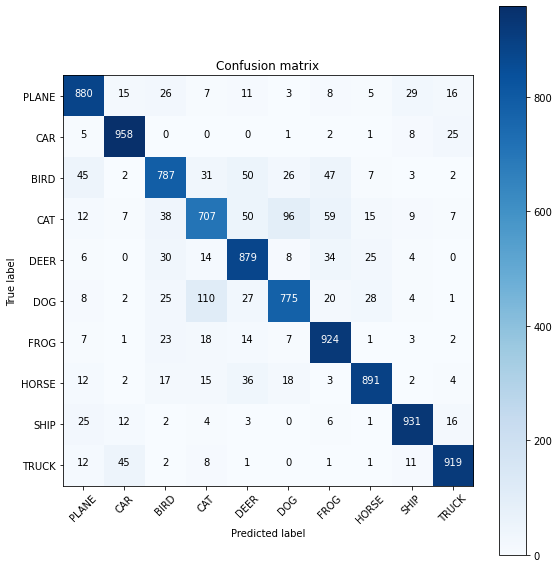

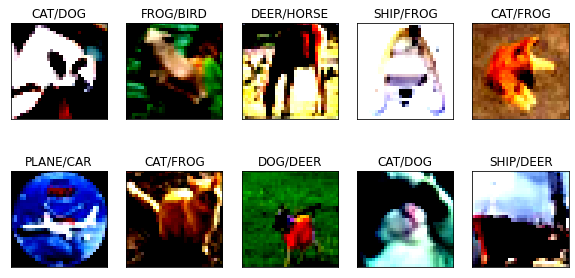

In [309]:
# Visualize network performance

from woolly.visualize import plot_network_performance
from woolly.utils import get_incorrrect_predictions
from woolly.visualize import plot_incorrect_predictions

from woolly.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from woolly.visualize import plot_confusion_matrix


#     trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

all_preds, all_targets = get_all_predictions(trainer.model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

incorrect = get_incorrrect_predictions(trainer.model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)